# Lab Assignment Six: Convolutional Network Architectures

***Sahil Johari, Prabhat Pal, Pritheesh Panchmahalkar, Azeem Merchant***
<hr>

# 1.Business Understanding

Our main prediction task is to classify the input images into 10 different classes which are present in this dataset. This prediction algorithm can be useful in recognizing objects from images. This would come in great use when we need to give word labels to images that are unlabelled. For example, in a gallery of images clicked using a camera, we can automatically run the recognition algorithm and label images. So that when a user wants to look at all the images of cars from an extensive photo gallery, it is as simple as typing ‘car’ into the search box. 
This can also be used to display similar looking images when the user does a search by image. The first step would be to tag the image that is entered into the search. Then we can find all the images that have similar tags and display them for the user. 

### Overview of the dataset

The image dataset selected is called STL-10 which is inspired by the CIFAR-10 dataset which we used in lab 4.
This image dataset contains 10 different classes of images mainly vehicles (airplanes, cars, trucks and ships) and animals (birds, cats, deer, dogs, horses and monkeys).
The images are all colored images of dimension 96x96 pixels each.
This image dataset contains 5000 training images (with 10 pre-defined folds) and another 800 test images per each class. The dataset contains an additional 100,000 unlabelled images for unsupervised learning. These additional 100,000 images may contain other types of images such as other animals (bears and rabbits) and other vehicles (trains and buses) that are not present in the STL-10 dataset. 
These images were sourced from labelled images on ImageNet.
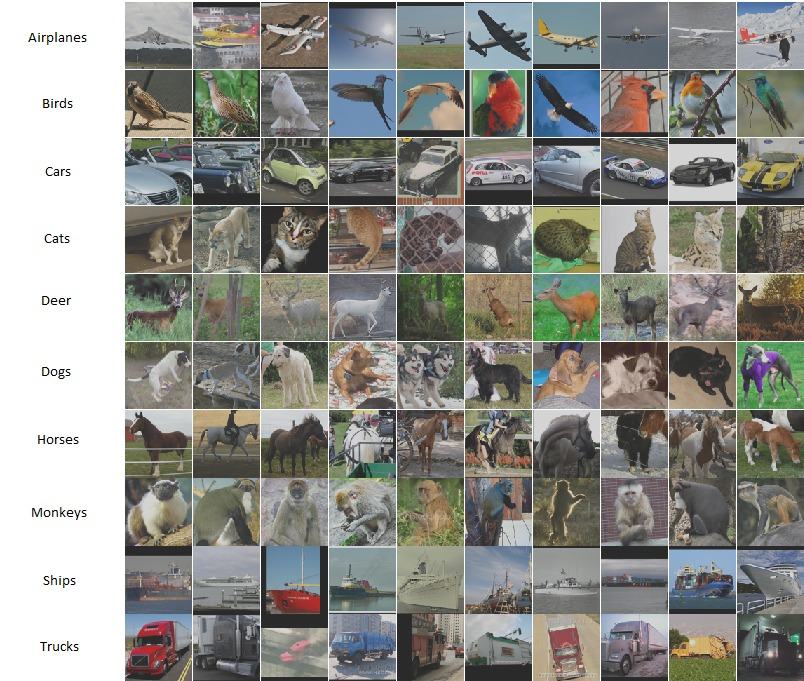

# 2.Data Preparation

In this section, we are going to load the dataset and convert the images into grayscale format. Since the dataset has already been provided into separate training and testing sets, we will not be doing any data split here.

In [19]:
import os, sys
import h5py
import keras
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns


from keras import applications
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.callbacks import EarlyStopping
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential, Model, Input, load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from matplotlib.gridspec import GridSpec

from PIL import Image

from scipy import interp
from scipy.misc import imresize
from skimage.io import imshow
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics as mt
from sklearn.model_selection import StratifiedKFold

In [48]:
# https://github.com/mttk/STL10/blob/master/stl10_input.py

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images
 

In [75]:
#Loading the images and labels from their binary formats

# path to the binary train file with image data
DATA_PATH_TRAIN = 'dataset/train_X.bin'
DATA_PATH_TEST = 'dataset/test_X.bin'

# path to the binary train file with labels
LABEL_PATH_TRAIN = 'dataset/train_y.bin'
LABEL_PATH_TEST = 'dataset/test_y.bin'

train_images_X = read_all_images(DATA_PATH_TRAIN)
train_labels_y = read_labels(LABEL_PATH_TRAIN)

test_images_X = read_all_images(DATA_PATH_TEST)
test_labels_y = read_labels(LABEL_PATH_TEST)

In [50]:
# converting to gray scale
X_train = []
y_train = []
flattened = []
size = 96,96

i = 0
for image in train_images_X:
    img = Image.fromarray(image)
    img = img.convert(mode='L')
    img_resized = img.resize(size, Image.ANTIALIAS)
    flattened.append(np.array(img_resized).flatten()/255-0.5)
    y_train.append(train_labels_y[i]-1)
    i += 1

X_train = np.array(flattened)
y_train = np.array(y_train)

In [51]:
h, w = np.array(img_resized).shape

n_samples, n_features = X_train.shape 
n_classes = len(set(y_train))

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print("Original Image Sizes {} by {}".format(h,w))
print("Shape: {}".format(X_train.shape))
print(np.min(X_train), np.max(X_train))

n_samples: 5000
n_features: 9216
n_classes: 10
Original Image Sizes 96 by 96
Shape: (5000, 9216)
-0.5 0.5


In [52]:
# selecting 2000 random test images and converting to gray scale

random_instances = [i for i in range(8000)]
np.random.shuffle(random_instances)
test_indices = random_instances[:2000]

X_test = []
y_test = []
flattened = []

i = 0
for image in test_images_X:
    img = Image.fromarray(image)
    img = img.convert(mode='L')
    img_resized = img.resize(size, Image.ANTIALIAS)
    flattened.append(np.array(img_resized).flatten()/255-0.5)
    y_test.append(test_labels_y[i]-1)
    i += 1

X_test = np.array(flattened)
X_test = X_test[test_indices]

y_test = np.array(y_test)
y_test = y_test[test_indices]

In [53]:
print(X_test.shape, X_train.shape)

(2000, 9216) (5000, 9216)


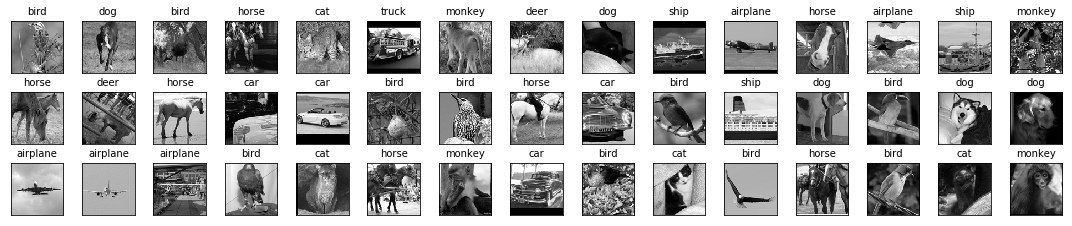

In [56]:
y_label = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]

def plot_gallery(images, titles, h, w, n_row=3, n_col=15):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1 * n_col, 1 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape(h, w), cmap=plt.cm.gray)
        plt.title(y_label[y_train[i]], size=10)
        plt.xticks(())
        plt.yticks(())
    plt.show()
        
plot_gallery(X_train[:45], "names", h, w)


Number of instances: 5000
Number of instances in each class: [500 500 500 500 500 500 500 500 500 500]


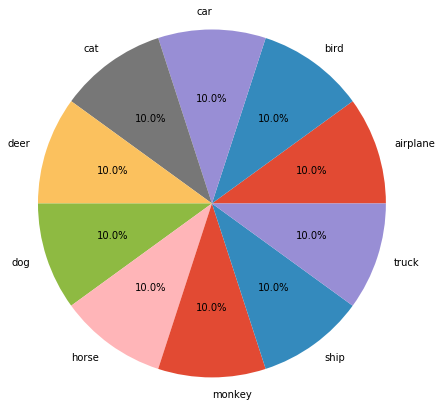

In [122]:
%matplotlib inline

plt.style.use('ggplot')

#=== Fill in code below========
print('Number of instances:', n_samples)
print('Number of instances in each class:', np.bincount(y_train))
the_grid = GridSpec(1, 1)

plt.subplot(the_grid[0, 0], aspect=1)
plt.pie(np.bincount(y_train), labels = y_label, autopct='%1.1f%%', radius=2)
plt.show()

# 3.Modeling

**Evaluation Metric**

There will not be True-negative and/or False-negative cases with our dataset as this is a multi-class problem and the prediction will be either same as the actual or it will be some other class. For example, let's say that we predicted an image to be a cat. In such case, the actual image can either be cat (True-positive) or any other class (False-positive). There is no case as (Actual: Not Cat, Predicted: Not Cat) or (Actual: Not Cat, Predicted: Cat).

Therefore, we think that the most logical approach for evaluating this dataset would be using Precision Score, which is defined as :

$$Precision = \frac{TP}{TP+FP}$$

We are using *Precision score* as an evaluation metric and setting the baseline at 50%. Since the accuracy of the algorithm is not very critical to the functioning of the program as a whole and is used more as a convenience for the user, a baseline of 50% precision is a good baseline to begin with. 
This problem is a multi-class prediction task, and the class distribution is uniform. Hence, we will use *micro-Precision score* to evaluate the performance of our classifier throughout this assignment. 

We decided to use micro-precision because the classes in the STL-10 dataset are completely unrelated. There is little to no relation between the different types of animals and vehicles that make up the dataset, hence micro-averaging is a more suitable approached to this problem. 

Time to prepare our data and target variables, and build custom convolutional networks.

In [6]:
NUM_CLASSES = 10
img_wh = 96

# one hot encoding the output values
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [7]:
X_train_cnn = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test_cnn = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
# the image data has been resized to (samples,image_rows,image_cols,image_channels)

#### Data Expansion

Here, we perform *Data Expansion* (or perturbation) on our training images. Essentially, we are going to rotate the images by 5 degrees (-5 or +5) and shifting the image by 0.1 units vertically as well as horizontally.

We want to avoid overfitting by perturbing the images to make sure that our model gets distinct images for training. Furthermore, our primary task is to recognize images, which is affected by a lot of factors such as object structure, angle of observation, perspective, distance from the camera, etc. Therefore, we are changing only the orientational parameters for our dataset.

In [8]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train_cnn)

### First Model

First, we build a 5-layer CNN with two filters - 32 filters & 64 filters.

In [38]:
def get_model_1():
    cnn = Sequential()
    num_filter_layers = [32, 64]
    
    for num_filters in num_filter_layers:
        cnn.add(Conv2D(filters=num_filters,
                        input_shape = (img_wh, img_wh, 1),
                        kernel_size=(3,3), 
                        padding='same', 
                        activation='relu')) # more compact syntax

        cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))


    # add one layer on flattened output
    cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
    cnn.add(Flatten())
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.25)) # add some dropout for regularization, again!
    cnn.add(Dense(NUM_CLASSES, activation='softmax'))

    # Let's train the model 
    cnn.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    
    
    return cnn

Next, we want to use a **cross-validation** technique which is appropriate to our dataset to divide it into training and testing sets. As we saw the class distribution earlier, they are all uniformly distributed. Out of 8000 test images (800 per class) we are using 2000 randomly selected test images so as to give us a **70/30 split** (approximately). 
Considering these facts about the data, we think that using **Stratified 4-Fold** cross-validation is going to be the best technique (possibly) to cross-validate the data. The purpose of using cross-validation is to create a model which is stable on validation sets which may be uncertain i.e. on each splitting iteration, the results may change. In our case, the validation set created using stratified 4-Folds does not cause instability because the data is uniformly distributed. Hence, we can say that the stratified 4-Fold generated model mirrors the practical usage of an algorithm.
We are not using Stratified 10-Fold cross-validation as it was proving to be very computationally expensive and unnecessary. 

Fold: 1, Precision: 0.530
Fold: 2, Precision: 0.542
Fold: 3, Precision: 0.518
Fold: 4, Precision: 0.528

CV precision: 0.529 +/- 0.009


(0.50759999999999994, 0.54159999999999997)

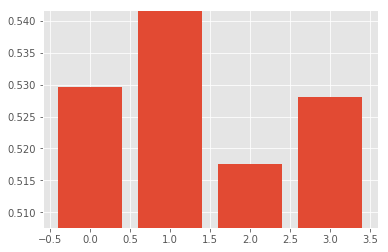

In [126]:
scores = []
i = 0
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=64)
for train_idx, test_idx in skf.split(X_train_cnn, y_train):
    # build train and test samples from crossed cols and feature cols
    X_train_temp = X_train_cnn[train_idx]
    y_train_temp = keras.utils.to_categorical(y_train[train_idx], NUM_CLASSES)
    X_test_temp = X_train_cnn[test_idx]
    y_test_temp = keras.utils.to_categorical(y_train[test_idx], NUM_CLASSES)
    
    # rebuild model
    cnn1 = get_model_1()

    # fit on train and predict on test
    cnn1.fit(X_train_temp, y_train_temp, epochs=35, batch_size=32, verbose=0)
    pred = np.argmax(cnn1.predict(X_test_temp), axis=1)
    
    # take cost
    s = mt.precision_score(y_train[test_idx], pred, average='micro')
    scores.append(s)
    
    print('Fold: %s, Precision: %.3f' % (i+1, s))
    i += 1
print('\nCV precision: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

plt.bar(range(len(scores)),scores)
plt.ylim([min(scores)-0.01,max(scores)])

In [127]:
%time
cnn1= get_model_1()

history_cnn1 = cnn1.fit_generator(datagen.flow(X_train_cnn, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train_cnn)/128), # how many generators to go through per epoch
                   epochs=10, verbose=1,
                   validation_data=(X_test_cnn,y_test_ohe)
                  )

yhat = np.argmax(cnn1.predict(X_test_cnn), axis=1)
print("Precision score: " + str(mt.precision_score(y_test,yhat, average='micro')))

cnn1.save('models/stl_cnn1.h5')

Wall time: 0 ns
Epoch 1/10
39/39 [==============================] - 103s 3s/step - loss: 2.2249 - acc: 0.1831 - val_loss: 1.9423 - val_acc: 0.2770
Epoch 2/10
39/39 [==============================] - 98s 3s/step - loss: 1.9958 - acc: 0.2644 - val_loss: 1.6655 - val_acc: 0.3910
Epoch 3/10
39/39 [==============================] - 100s 3s/step - loss: 1.8062 - acc: 0.3206 - val_loss: 1.5641 - val_acc: 0.4185
Epoch 4/10
39/39 [==============================] - 99s 3s/step - loss: 1.6839 - acc: 0.3681 - val_loss: 1.4963 - val_acc: 0.4290
Epoch 5/10
39/39 [==============================] - 101s 3s/step - loss: 1.6434 - acc: 0.4038 - val_loss: 1.4276 - val_acc: 0.4750
Epoch 6/10
39/39 [==============================] - 100s 3s/step - loss: 1.5670 - acc: 0.4220 - val_loss: 1.3896 - val_acc: 0.4850
Epoch 7/10
39/39 [==============================] - 99s 3s/step - loss: 1.5050 - acc: 0.4403 - val_loss: 1.2938 - val_acc: 0.5295
Epoch 8/10
39/39 [==============================] - 98s 3s/step - loss

### Second Model

In this model, we have used L2 regularization along with *Kaiming He* kernel initializer to regularize ReLU layers. Again, we used 32-filters, but twice.

In [128]:
# Use Kaiming He to regularize ReLU layers: https://arxiv.org/pdf/1502.01852.pdf
# Use Glorot/Bengio for linear/sigmoid/softmax: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf 
 
l2_lambda = 0.0001

def get_model_2():
    cnn = Sequential()
    num_filter_layers = [32, 32]

    for num_filters in num_filter_layers:
        cnn.add(Conv2D(filters=num_filters,
                       input_shape = (img_wh, img_wh, 1),
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu')) # more compact syntax
        cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))



    # add one layer on flattened output
    cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
    cnn.add(Flatten())
    cnn.add(Dense(256, 
                  activation='relu',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=l2(l2_lambda)
           ))
    cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
    cnn.add(Dense(NUM_CLASSES, 
                  activation='softmax', 
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=l2(l2_lambda)
                 ))

    # Let's train the model 
    cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                  optimizer='rmsprop', # 'adadelta' 'rmsprop'
                  metrics=['accuracy'])

    
    return cnn

Fold: 1, Precision: 0.518
Fold: 2, Precision: 0.527
Fold: 3, Precision: 0.518
Fold: 4, Precision: 0.490

CV precision: 0.513 +/- 0.014


(0.47959999999999997, 0.5272)

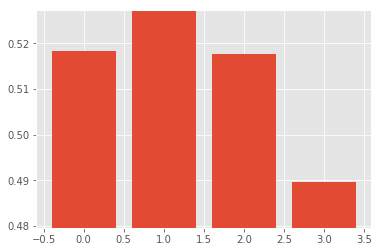

In [129]:
scores = []
i = 0
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=64)
for train_idx, test_idx in skf.split(X_train_cnn, y_train):
    # build train and test samples from crossed cols and feature cols
    X_train_temp = X_train_cnn[train_idx]
    y_train_temp = keras.utils.to_categorical(y_train[train_idx], NUM_CLASSES)
    X_test_temp = X_train_cnn[test_idx]
    y_test_temp = keras.utils.to_categorical(y_train[test_idx], NUM_CLASSES)
    
    # rebuild model
    cnn2 = get_model_2()

    # fit on train and predict on test
    cnn2.fit(X_train_temp, y_train_temp, epochs=35, batch_size=32, verbose=0)
    pred = np.argmax(cnn2.predict(X_test_temp), axis=1)
    
    # take cost
    s = mt.precision_score(y_train[test_idx], pred, average='micro')
    scores.append(s)
    
    print('Fold: %s, Precision: %.3f' % (i+1, s))
    i += 1
print('\nCV precision: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

plt.bar(range(len(scores)),scores)
plt.ylim([min(scores)-0.01,max(scores)])

In [149]:
%time
cnn2= get_model_2()

history_cnn2 = cnn2.fit_generator(datagen.flow(X_train_cnn, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train_cnn)/128), # how many generators to go through per epoch
                   epochs=10, verbose=1,
                   validation_data=(X_test_cnn, y_test_ohe)
                  )

yhat = np.argmax(cnn2.predict(X_test_cnn), axis=1)
print("Precision score: " + str(mt.precision_score(y_test,yhat, average='micro')))

cnn2.save('models/stl_cnn2.h5')

Wall time: 0 ns
Epoch 1/10
39/39 [==============================] - 78s 2s/step - loss: 2.6876 - acc: 0.2098 - val_loss: 1.8516 - val_acc: 0.3610
Epoch 2/10
39/39 [==============================] - 75s 2s/step - loss: 1.8999 - acc: 0.3243 - val_loss: 1.6720 - val_acc: 0.4060
Epoch 3/10
39/39 [==============================] - 76s 2s/step - loss: 1.7623 - acc: 0.3771 - val_loss: 1.5662 - val_acc: 0.4575
Epoch 4/10
39/39 [==============================] - 114s 3s/step - loss: 1.6717 - acc: 0.4071 - val_loss: 1.4660 - val_acc: 0.4910
Epoch 5/10
39/39 [==============================] - 120s 3s/step - loss: 1.6011 - acc: 0.4389 - val_loss: 1.4517 - val_acc: 0.4985
Epoch 6/10
39/39 [==============================] - 125s 3s/step - loss: 1.5553 - acc: 0.4706 - val_loss: 1.4322 - val_acc: 0.5135
Epoch 7/10
39/39 [==============================] - 120s 3s/step - loss: 1.5275 - acc: 0.4650 - val_loss: 1.3975 - val_acc: 0.5170
Epoch 8/10
39/39 [==============================] - 118s 3s/step - los

Comparing both the models based on their precision score and training loss

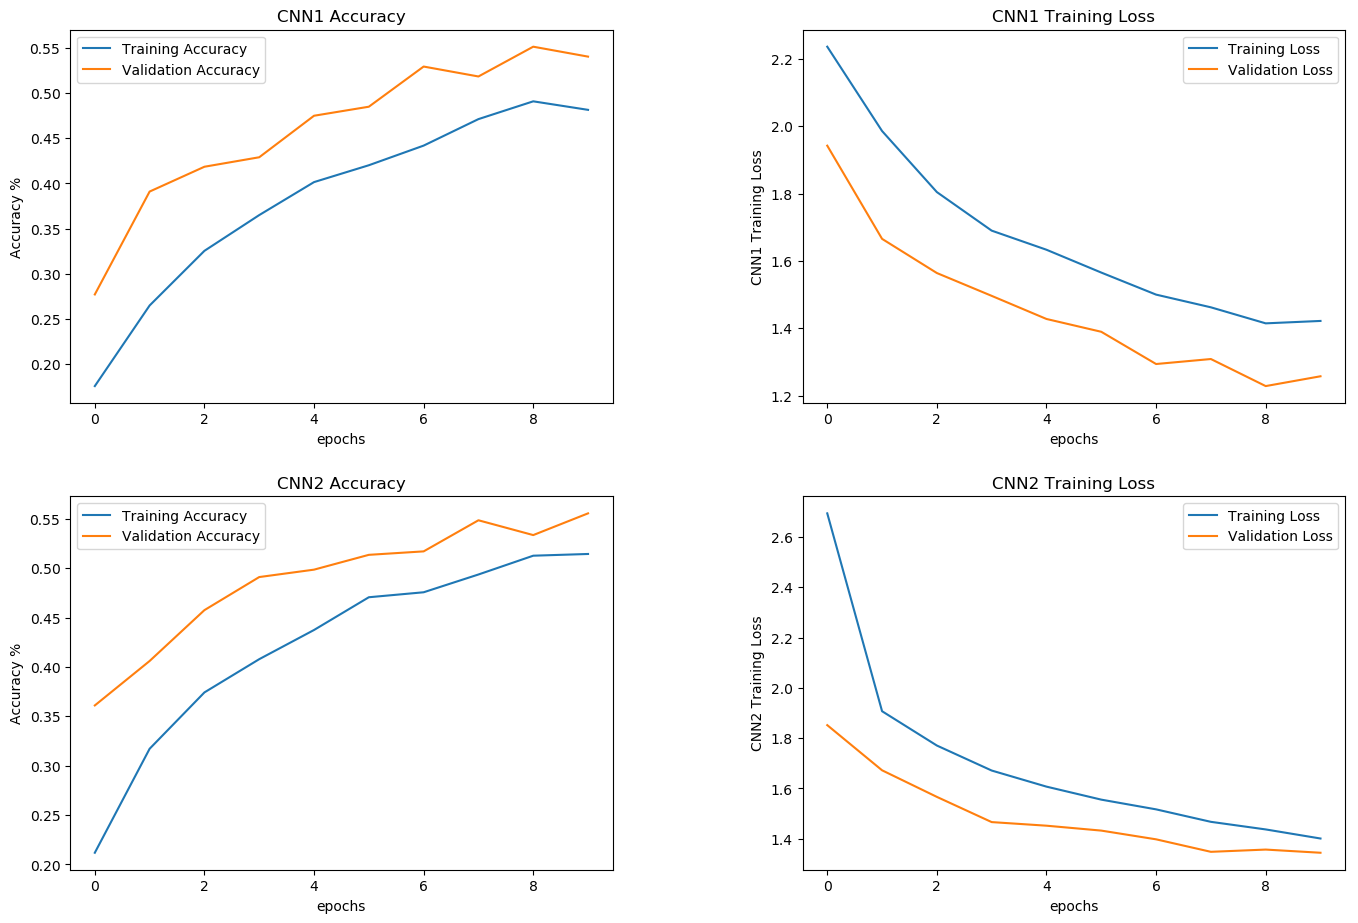

In [158]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.subplot(2,2,1)
plt.plot(history_cnn1.history['acc'], label="Training Accuracy")
plt.plot(history_cnn1.history['val_acc'], label="Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy %')
plt.title('CNN1 Accuracy')
plt.legend(loc='best')

plt.subplot(2,2,2)
plt.plot(history_cnn1.history['loss'], label="Training Loss")
plt.plot(history_cnn1.history['val_loss'], label="Validation Loss")
plt.xlabel('epochs')
plt.ylabel('CNN1 Training Loss')
plt.title('CNN1 Training Loss')
plt.legend(loc='best')

plt.subplot(2,2,3)
plt.plot(history_cnn2.history['acc'], label="Training Accuracy")
plt.plot(history_cnn2.history['val_acc'], label="Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy %')
plt.title('CNN2 Accuracy')
plt.legend(loc='best')

plt.subplot(2,2,4)
plt.plot(history_cnn2.history['loss'], label="Training Loss")
plt.plot(history_cnn2.history['val_loss'], label="Validation Loss")
plt.xlabel('epochs')
plt.ylabel('CNN2 Training Loss')
plt.title('CNN2 Training Loss')
plt.legend(loc='best')

Now, we want to investigate the performances of our models by changing certain parameters. For this, we first train our models on four different values of *epochs* and visualize the result.

In [159]:
cnn1_scores = []
cnn2_scores = []

cnn1 = load_model('models/stl_cnn1.h5')
cnn2 = load_model('models/stl_cnn2.h5')

for epoch in [5, 10, 20, 50]: 
    cnn1.fit_generator(datagen.flow(X_train_cnn, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train_cnn)/128), # how many generators to go through per epoch
                   epochs=epoch, verbose=0,
                   validation_data=(X_test_cnn, y_test_ohe)
                  )

    yhat = np.argmax(cnn1.predict(X_test_cnn), axis=1)
    cnn1_scores.append(mt.precision_score(y_test,yhat, average='micro'))
    
    cnn2.fit_generator(datagen.flow(X_train_cnn, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train_cnn)/128), # how many generators to go through per epoch
                   epochs=epoch, verbose=0,
                   validation_data=(X_test_cnn, y_test_ohe)
                  )

    yhat = np.argmax(cnn2.predict(X_test_cnn), axis=1)
    cnn2_scores.append(mt.precision_score(y_test,yhat, average='micro'))

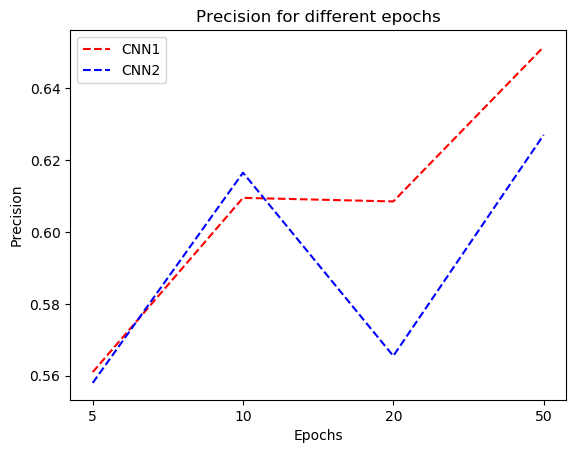

CNN 1: [0.56100000000000005, 0.60950000000000004, 0.60850000000000004, 0.65149999999999997]
CNN 2: [0.55800000000000005, 0.61650000000000005, 0.5655, 0.627]


In [247]:
plt.plot(cnn1_scores, 'r--', label="CNN1")
plt.plot(cnn2_scores, 'b--', label="CNN2")
plt.xticks(np.arange(4), ('5', '10', '20', '50'))
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Epochs")
plt.title("Precision for different epochs")
plt.show()

print("CNN 1:", cnn1_scores)
print("CNN 2:", cnn2_scores)

As we can see, both the models perform their best on 50 epochs. Hence, we will use it for our comparison with multi-layer perceptron later in this assignment.

Let us change the *batch size* and see how the models perform. For this, we will use batches of 32 and 64.

In [166]:
cnn1_scores_bs = []
cnn2_scores_bs = []

for batch in [32, 64]: 
    print("Model 1\n")
    cnn1.fit_generator(datagen.flow(X_train_cnn, y_train_ohe, batch_size=batch), 
                   steps_per_epoch=int(len(X_train_cnn)/batch), # how many generators to go through per epoch
                   epochs=50, verbose=1,
                   validation_data=(X_test_cnn, y_test_ohe),
                    callbacks = [EarlyStopping(monitor='val_loss', patience=4)]
                  )

    yhat = np.argmax(cnn1.predict(X_test_cnn), axis=1)
    cnn1_scores_bs.append(mt.precision_score(y_test,yhat, average='micro'))
    print("Model 2\n")
    cnn2.fit_generator(datagen.flow(X_train_cnn, y_train_ohe, batch_size=batch), 
                   steps_per_epoch=int(len(X_train_cnn)/batch), # how many generators to go through per epoch
                   epochs=50, verbose=1,
                   validation_data=(X_test_cnn, y_test_ohe), 
                    callbacks = [EarlyStopping(monitor='val_loss', patience=4)]
                  )

    yhat = np.argmax(cnn2.predict(X_test_cnn), axis=1)
    cnn2_scores_bs.append(mt.precision_score(y_test,yhat, average='micro'))
    print("\nBatch of %s completed\n" % str(batch))

Model 1

Epoch 1/50
156/156 [==============================] - 120s 766ms/step - loss: 0.9590 - acc: 0.6871 - val_loss: 1.3716 - val_acc: 0.6015
Epoch 2/50
156/156 [==============================] - 119s 765ms/step - loss: 1.0065 - acc: 0.6731 - val_loss: 1.1662 - val_acc: 0.6140
Epoch 3/50
156/156 [==============================] - 119s 763ms/step - loss: 0.9906 - acc: 0.6701 - val_loss: 1.1867 - val_acc: 0.6285
Epoch 4/50
156/156 [==============================] - 119s 763ms/step - loss: 0.9978 - acc: 0.6701 - val_loss: 1.2771 - val_acc: 0.6460
Epoch 5/50
156/156 [==============================] - 122s 779ms/step - loss: 0.9914 - acc: 0.6641 - val_loss: 1.3326 - val_acc: 0.6190
Epoch 6/50
156/156 [==============================] - 119s 764ms/step - loss: 1.0307 - acc: 0.6601 - val_loss: 1.7384 - val_acc: 0.6365
Model 2

Epoch 1/50
156/156 [==============================] - 87s 558ms/step - loss: 1.3420 - acc: 0.6340 - val_loss: 1.6580 - val_acc: 0.5645
Epoch 2/50
156/156 [===========

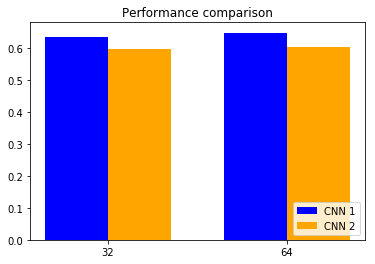

CNN 1 [32, 64]: [0.6365, 0.6495]
CNN 2 [32, 64]: [0.5985, 0.6045]


In [72]:
##### Reference: Matplotlib - Group bar charts with units (https://matplotlib.org/gallery/units/bar_unit_demo.html)
batches = ['32', '64']

N = 2
fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars

p1 = ax.bar(ind, cnn1_scores_bs, width, color='blue', bottom=0)
p2 = ax.bar(ind + width, cnn2_scores_bs, width, color='orange', bottom=0)

ax.set_title('Performance comparison')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(batches)

ax.legend((p1[0], p2[0]), ('CNN 1', 'CNN 2'), loc='lower right')
ax.autoscale_view()

plt.show()

print("CNN 1 [32, 64]:",cnn1_scores_bs)
print("CNN 2 [32, 64]:",cnn2_scores_bs)

Based on the graph above, CNN1 is the best performer with 50 epochs and 64 batch size. Also, when we used 128 batches to train our models, they did not perform as good as with batch size of 64.

Hence, we will use this model (CNN1) to compare with MLP.

In [248]:
# make a 4 layer keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=X_train.shape[1], units=150, activation='relu') )
mlp.add(Dropout(0.5))
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=50, 
        shuffle=True, verbose=1)

Epoch 1/50
5000/5000 [==============================] - 12s 2ms/step - loss: 2.3006 - acc: 0.1386
Epoch 2/50
5000/5000 [==============================] - 6s 1ms/step - loss: 2.1690 - acc: 0.1906
Epoch 3/50
5000/5000 [==============================] - 6s 1ms/step - loss: 2.1222 - acc: 0.1924
Epoch 4/50
5000/5000 [==============================] - 6s 1ms/step - loss: 2.0621 - acc: 0.2148
Epoch 5/50
5000/5000 [==============================] - 6s 1ms/step - loss: 2.0284 - acc: 0.2232
Epoch 6/50
5000/5000 [==============================] - 6s 1ms/step - loss: 1.9917 - acc: 0.2382
Epoch 7/50
5000/5000 [==============================] - 6s 1ms/step - loss: 1.9598 - acc: 0.2528
Epoch 8/50
5000/5000 [==============================] - 6s 1ms/step - loss: 1.9411 - acc: 0.2716
Epoch 9/50
5000/5000 [==============================] - 6s 1ms/step - loss: 1.9141 - acc: 0.2824
Epoch 10/50
5000/5000 [==============================] - 6s 1ms/step - loss: 1.8856 - acc: 0.2990
Epoch 11/50
5000/5000 [=====

In [61]:
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test_cnn), axis=1)
        acc_cnn = mt.precision_score(y_test,yhat_cnn, average='micro')
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(pd.DataFrame(cm, y_label, y_label), annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.precision_score(y_test,yhat_mlp, average='micro')
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(pd.DataFrame(cm, y_label, y_label),annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

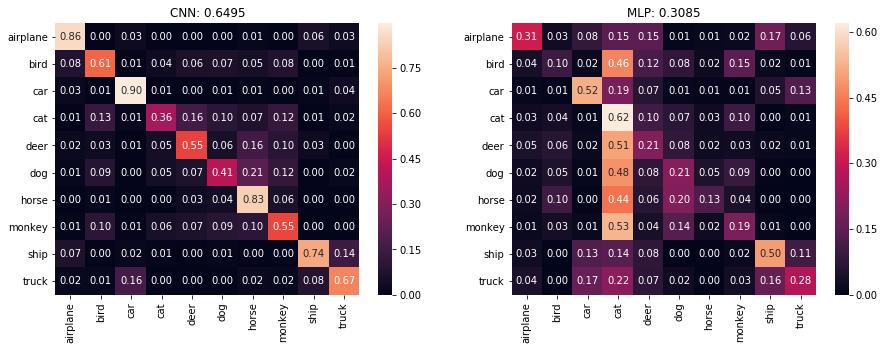

In [250]:
compare_mlp_cnn(cnn1,mlp,X_test,y_test)

It is quite clear from above visualization that our custom CNN is almost twice as good as the MLP. Also, it did much better than our baseline expectation, which was 50%. Hence, we can propose this model for deployment.

Let us perform a statistical comparison using **Receiver Operating Characteristics (ROC)** and **Area under the Curve (AUC)**.

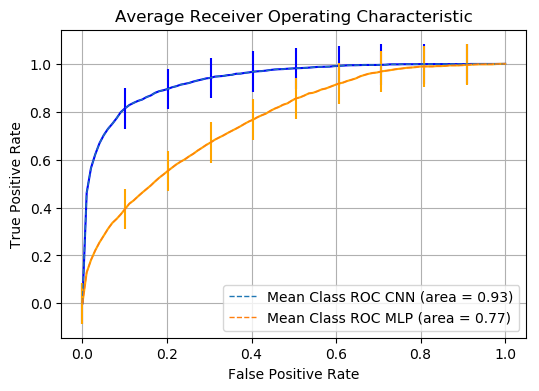

In [251]:
K = 4

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

pred = cnn1.predict(X_test_cnn)
pred_mlp = mlp.predict_proba(X_test)

# ROC for CNN
perclass_mean_tpr = 0.0
roc_auc = 0
classes = np.unique(y_train)

# get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_test,
                                     pred[:,int(j)],
                                     pos_label=j)
    
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)

perclass_mean_tpr /= len(classes)
roc_auc /= len(classes)
mean_tpr += perclass_mean_tpr
error = np.var(mean_fpr)
plt.style.use('default')

plt.figure(figsize=(6,4))
plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC CNN (area = %0.2f)'
               % (roc_auc))
plt.errorbar(mean_fpr, perclass_mean_tpr, yerr=error, barsabove=True, errorevery=10, color='blue')


# ROC for MLP
perclass_mean_tpr = 0.0
roc_auc = 0

# get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_test,
                                     pred_mlp[:,int(j)],
                                     pos_label=j)
    
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)

perclass_mean_tpr /= len(classes)
roc_auc /= len(classes)
mean_tpr += perclass_mean_tpr

error = np.var(mean_fpr)


plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC MLP (area = %0.2f)'
               % (roc_auc))
plt.errorbar(mean_fpr, perclass_mean_tpr, yerr=error, barsabove=True, errorevery=10, color='orange')

plt.legend(loc='best')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average Receiver Operating Characteristic')
plt.show()

From the above comparison, it is clear that the MLP is not as good as our custom CNN. The true positive rate for CNN appears to raise much faster than MLP. Furthermore, the AUC for CNN is marginally greater than MLP with the value of 0.93.

# 4.Exceptional Work

In this section, we are going to use transfer learning using the pre-trained weights of **ResNet50** model for our CNN. For this, we will create a simple ResNet model with 2 dense layers at the end of it. Then, we will train this model with our dataset. We will capture the weights of a single layer of this model. These weights will be used for the initial layer of another custom CNN, which is very similar to our previous model (CNN 1). After all these steps, we train this model with our dataset.

To do this, we begin by upscaling our images from 96 x 96 pixels to 224 x 224 pixels.

In [24]:
%%time
x_train_up = [imresize(x,size=(224,224,3), interp='nearest') for x in images_X]
x_train_up = np.stack(x_train_up,axis=0)
print(x_train_up.shape)

x_test_up = [imresize(x,size=(224,224,3), interp='nearest') for x in images_y[test_indices]]
x_test_up = np.stack(x_test_up,axis=0)
print(x_test_up.shape)

(5000, 96, 96, 3)
(2000, 96, 96, 3)
Wall time: 3.34 s


Next, we load ResNet50 and capture the weights from it's layers.

In [28]:
res_model = ResNet50(weights='imagenet')

In [27]:
# connect new layers to the output
x = res_model.output

# let's add a fully-connected layer
x = Dense(1024, activation='relu',kernel_initializer='he_uniform')(x)

predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=res_model.input, outputs=predictions)

# freeze ResNet during training
for layer in res_model.layers:
    layer.trainable = False
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train_up,y_train_ohe,epochs=1,batch_size=64,verbose=1)

In [291]:
model.save('models/resnet.h5')

In [400]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

We create our CNN model and use parameters which are compatible with the weights captured from ResNet in order to transfer them for learning.

In [33]:
cnn_pre = Sequential()
img_input = Input(shape=(96, 96, 1))

cnn_pre = Conv2D(filters=3,
                kernel_size=(7,7), 
                padding='same', 
                activation='relu')(img_input)

cnn_pre = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(cnn_pre)

cnn_pre = Conv2D(filters=64,
                input_shape = (img_wh, img_wh, 1),
                kernel_size=(7,7), 
                padding='same', 
                activation='relu')(cnn_pre)

cnn_pre = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(cnn_pre)


# add one layer on flattened output
cnn_pre = Dropout(0.25)(cnn_pre)
cnn_pre = Flatten()(cnn_pre)
cnn_pre = Dense(256, activation='relu')(cnn_pre)
cnn_pre = Dropout(0.5)(cnn_pre)
cnn_pre = Dense(128, activation='relu')(cnn_pre)
cnn_pre = Dropout(0.25)(cnn_pre)
cnn_pre = Dense(NUM_CLASSES, activation='softmax')(cnn_pre)

cnn_pre_train = Model(input = img_input, output = cnn_pre)
cnn_pre_train.layers[3].trainable = False
cnn_pre_train.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 96, 96, 3)         150       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 64)        9472      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 36864)             0         
__________

C:\Users\sahil\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [12]:
layer_dict = dict([(layer.name, layer) for layer in cnn_pre_train.layers])
layer_names = [layer.name for layer in cnn_pre_train.layers]

In [13]:
weights_path = 'models/resnet.h5'
f = h5py.File(weights_path)

In [81]:
f["model_weights"]["conv1"].attrs["weight_names"]

array([b'conv1/kernel:0', b'conv1/bias:0'],
      dtype='|S14')

In [29]:
weights = f["model_weights"]["conv1"]["conv1/kernel:0"]

In [34]:
cnn_pre_train.layers[3].set_weights([weights, np.zeros((weights.shape[3],))])

In [36]:
cnn_pre_train.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])

cnn_pre_train.fit_generator(datagen.flow(X_train_cnn, y_train_ohe, batch_size=64), 
               steps_per_epoch=int(len(X_train_cnn)/64),
               epochs=50, verbose=1,
               validation_data=(X_test_cnn, y_test_ohe),
                callbacks = [EarlyStopping(monitor='val_loss', patience=4)]
                           )

Epoch 1/50
78/78 [==============================] - 88s 1s/step - loss: 2.1639 - acc: 0.1877 - val_loss: 1.8761 - val_acc: 0.3220
Epoch 2/50
78/78 [==============================] - 86s 1s/step - loss: 1.9590 - acc: 0.2508 - val_loss: 1.7457 - val_acc: 0.3050
Epoch 3/50
78/78 [==============================] - 95s 1s/step - loss: 1.8703 - acc: 0.2814 - val_loss: 1.7413 - val_acc: 0.3585
Epoch 4/50
78/78 [==============================] - 86s 1s/step - loss: 1.8173 - acc: 0.2890 - val_loss: 1.6151 - val_acc: 0.3895
Epoch 5/50
78/78 [==============================] - 87s 1s/step - loss: 1.7757 - acc: 0.3151 - val_loss: 1.6813 - val_acc: 0.3775
Epoch 6/50
78/78 [==============================] - 86s 1s/step - loss: 1.7534 - acc: 0.3243 - val_loss: 1.5633 - val_acc: 0.4200
Epoch 7/50
78/78 [==============================] - 86s 1s/step - loss: 1.7288 - acc: 0.3249 - val_loss: 1.7132 - val_acc: 0.3740
Epoch 8/50
78/78 [==============================] - 86s 1s/step - loss: 1.6907 - acc: 0.34

For the CNN built from scratch, the final validation accuracy was 64.95 %, whereas for the CNN built on pretrained weights from ResNet50 model, we achieved a validation accuracy of 46.70 %. Contrary to our expectations, the CNN (from scratch) performed better on training set.

**Due to time-constraints, we were unable to perform prediction on this model.**

# References

* http://cs231n.github.io/convolutional-networks/
* https://en.wikipedia.org/wiki/Residual_neural_network
* https://cs.stanford.edu/~acoates/stl10/
* http://www.image-net.org/
* https://en.wikipedia.org/wiki/Precision_and_recall
* https://en.wikipedia.org/wiki/Cross-validation_(statistics)
* https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8
* https://github.com/mttk/STL10/blob/master/stl10_input.py
* https://github.com/eclarson/MachineLearningNotebooks/blob/master/11.%20Convolutional%20Neural%20Networks.ipynb
* https://github.com/eclarson/MachineLearningNotebooks/blob/master/12.%20More%20Advanced%20CNN%20Techniques.ipynb